## Problem 2 - Stitching
Code and steps addapted from https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb

In [3]:
from __future__ import division, print_function
%matplotlib inline

First things first
Import NumPy and matplotlib, then define a utility function to compare multiple images

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

**Load data**

In [7]:
import skimage.io as io
pano_imgs = io.ImageCollection('/Users/Charlie/Desktop/python-seminar/Homeworks/hw_7/PanoImages/IMG_*')

Inspect these images using the convenience function compare() defined earlier

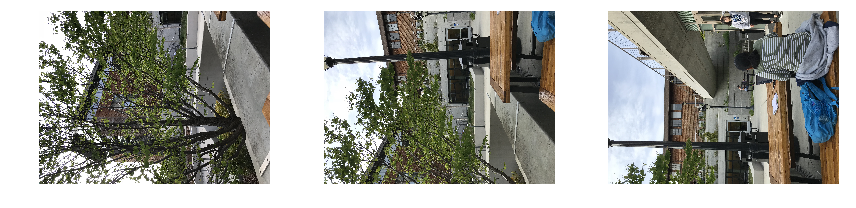

In [8]:
compare(*pano_imgs, figsize=(12, 10))

# 0. Pre-processing
Resizing, often downscaling with fixed aspect ratio, conversion to grayscale, cropping to region(s) of interest, etc...

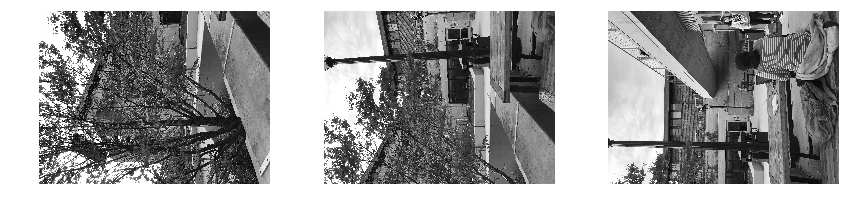

In [9]:
from skimage.color import rgb2gray

pano1, pano2, pano3 = [rgb2gray(im) for im in pano_imgs]
# View the results
compare(pano1, pano2, pano3, figsize=(12, 10))

# 1. Feature detection and matching
We need to estimate a projective transformation that relates these images together. The steps will be:
1. Define one image as a target or destination image, which will remain anchored while the others are warped
2. Detect features in all three images
3. Match features from left and right images against the features in the center, anchored image.

In this five-shot series, the middle image pano2 is the logical anchor point.
We detect "Oriented FAST and rotated BRIEF" (ORB) features in both images.

Note: For efficiency, in this tutorial we're finding 800 keypoints. The results are good but small variations are expected. If you need a more robust estimate in practice, run multiple times and pick the best result or generate additional keypoints.

In [ ]:
from skimage.feature import ORB

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect keypoints in pano2
orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

# Detect keypoints in pano3
orb.detect_and_extract(pano3)
keypoints3 = orb.keypoints
descriptors3 = orb.descriptors

Match features to the center image

In [183]:
from skimage.feature import match_descriptors

# Match descriptors between left/right images and the center
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches23 = match_descriptors(descriptors2, descriptors3, cross_check=True)

Inspect these matched features side-by-side using the convenience function skimage.feature.plot_matches.

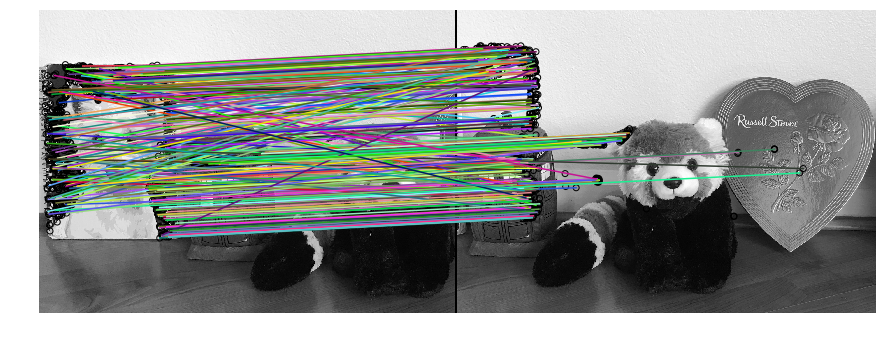

In [184]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12)
ax.axis('off');


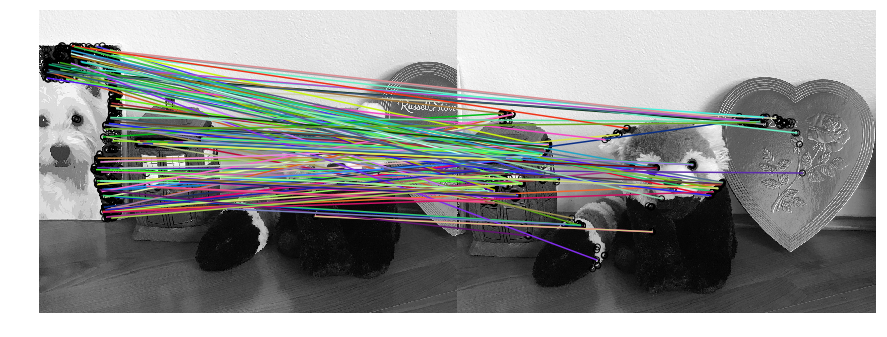

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano1 -> pano2
plot_matches(ax, pano2, pano3, keypoints2, keypoints3, matches23)
ax.axis('off');

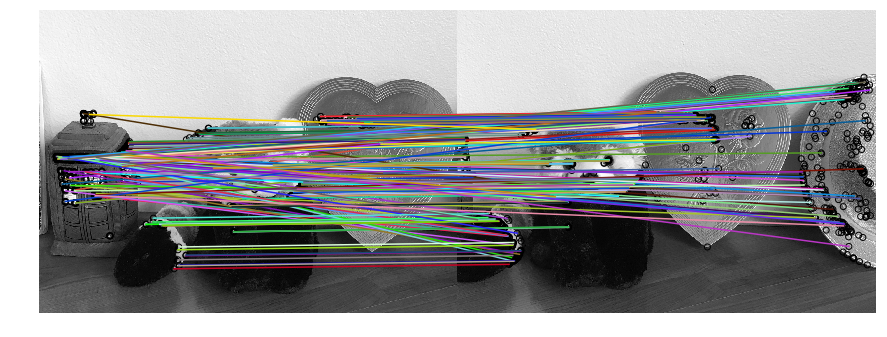

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano1 -> pano2
plot_matches(ax, pano2, pano3, keypoints2, keypoints3, matches23)
ax.axis('off');

# 2. Transform estimation
To filter out the false matches, we apply RANdom SAmple Consensus (RANSAC), a powerful method of rejecting outliers available in skimage.transform.ransac. The transformation is estimated iteratively, based on randomly chosen subsets, finally selecting the model which corresponds best with the majority of matches.

We need to do this 4 times, once each for the transforms towards the center image
1. far left -> center
2. left -> center 
3. center <- right 
4. center <- far right

Order here matters!

In [188]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

#1) Map far left onto center
#   * source (image to be registered): pano0
#   * target (reference image): pano2, the frame frame registration for left most target
src = keypoints0[matches02[:, 0]][:, ::-1]
dst = keypoints2[matches02[:, 1]][:, ::-1]

model_robust02, inliers02 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

#2) Map inner left to center
#   * source (image to be registered): pano1
#   * target (reference image): pano2, our middle frame registration target
src = keypoints1[matches12[:, 0]][:, ::-1]
dst = keypoints2[matches12[:, 1]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

#3) Map inner right to center
#   * source (image to be registered): pano3
#   * target (reference image): pano2, our middle frame registration target
src = keypoints3[matches23[:, 1]][:, ::-1]
dst = keypoints2[matches23[:, 0]][:, ::-1]

model_robust23, inliers23 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

#4) Map far right onto center
#   * source (image to be registered): pano4
#   * target (reference image): pano3, our middle frame registration target
src = keypoints4[matches24[:, 1]][:, ::-1]
dst = keypoints2[matches24[:, 0]][:, ::-1]

model_robust24, inliers24 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

The inliers returned from RANSAC select the best subset of matches. How do they look?

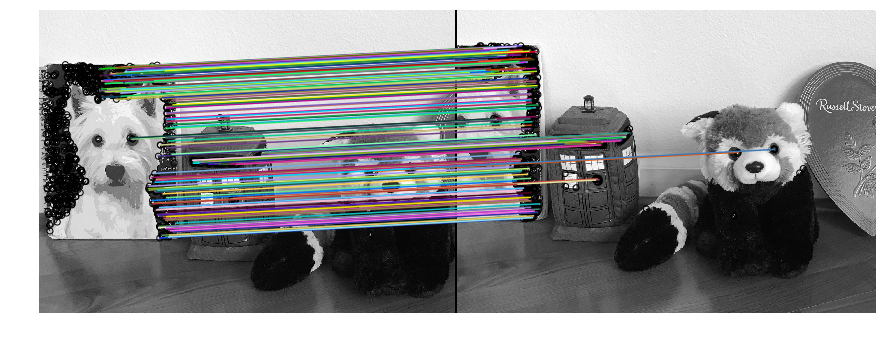

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])

ax.axis('off');

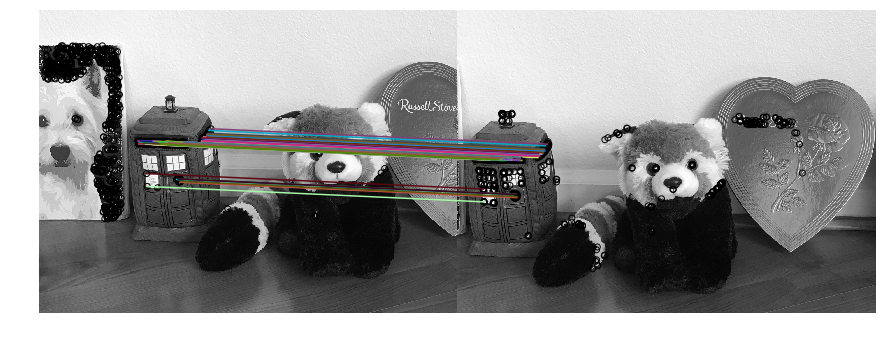

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12[inliers12])

ax.axis('off');

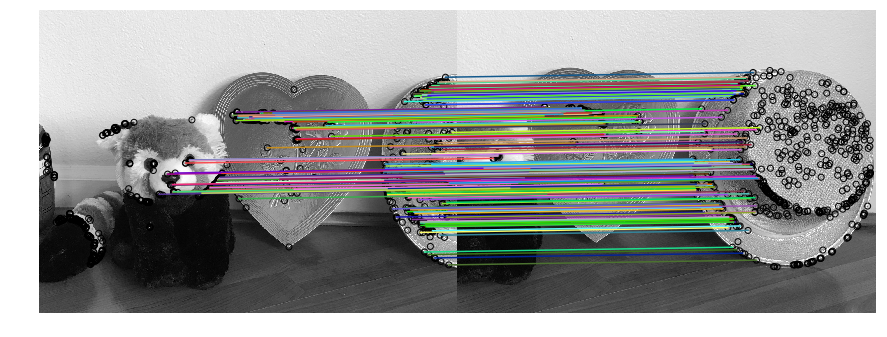

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano3 -> pano4
plot_matches(ax, pano3, pano4, keypoints3, keypoints4, matches34[inliers34])

ax.axis('off');

# 3. Warping
Next, we produce the panorama itself. We must warp, or transform, the outside images so they will properly align with the stationary image.

**Extent of output image**

The first step is to find the shape of the output image to contain all transformed images. To do this we consider the outermost extents of the warped images.

In [263]:
from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = pano2.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners02 = model_robust02(corners)
warped_corners24 = model_robust24(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack(( warped_corners02, warped_corners24, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)


Apply estimated transforms

Warp the images with skimage.transform.warp according to the estimated models. A shift, or translation is needed to place as our middle image in the middle - it isn't truly stationary.
Values outside the input images are initially set to -1 to distinguish the "background", which is identified for later use.

Note: warp takes the inverse mapping as an input.

In [207]:
from skimage.transform import warp


# This in-plane offset is the only necessary transformation for the middle image
offset2 = SimilarityTransform(translation= -corner_min)

# Translate pano2 into place
pano2_warped = warp(pano2, offset2.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0


Working from inside out, warp left panel into place on center panel

In [208]:
# Warp pano1 (left) to pano2
transform12 = (model_robust12 + offset2).inverse
pano1_warped = warp(pano1, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

Do same, now on left side of center panel

In [209]:
# Warp pano3 (right) to pano2 
transform23 = (model_robust23 + offset2).inverse
pano3_warped = warp(pano3, transform23, order=3,
                    output_shape=output_shape, cval=-1)

pano3_mask = (pano3_warped != -1)  # Mask == 1 inside image
pano3_warped[~pano3_mask] = 0      # Return background values to 0

Let's check to make sure all is going smoothly

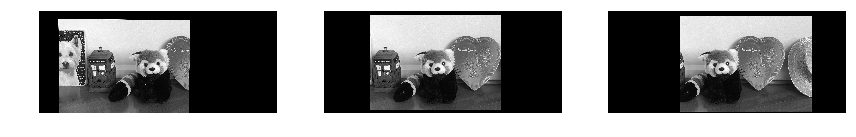

In [236]:
compare(pano1_warped, pano2_warped, pano3_warped, figsize=(12, 10));

Use the left and right panels to transform the the outermost panels now. 
We will need to use a new "in plane" reference for each outside image

In [237]:
# Starting on the far right, map pano0 to pano1
# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)


transform01 = (model_robust01 + offset2).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

In [238]:
# Now the far left, map pano4 to pano3
transform34 = (model_robust34 + offset2).inverse
pano4_warped = warp(pano4, transform34, order=3,
                    output_shape=output_shape, cval=-1)

pano4_mask = (pano4_warped != -1)  # Mask == 1 inside image
pano4_warped[~pano4_mask] = 0      # Return background values to 0

Lets check one more time to see if all 5 are aligned and placed in their relative locations.

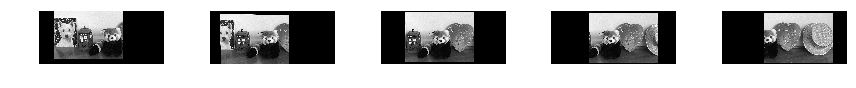

In [239]:
compare(pano0_warped, pano1_warped, pano2_warped, pano3_warped, pano4_warped, figsize=(12, 10));

In [240]:
# Add the images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = ( pano1_warped + pano2_warped + pano3_warped)

In [241]:
# Track the overlap by adding the masks together, only the center 3 are working rn...
overlap = ( # Multiply by 1.0 for bool -> float conversion
           pano1_mask * 1.0 + 
           pano2_mask * 1.0 +
           pano3_mask * 1.0 )

In [251]:
# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

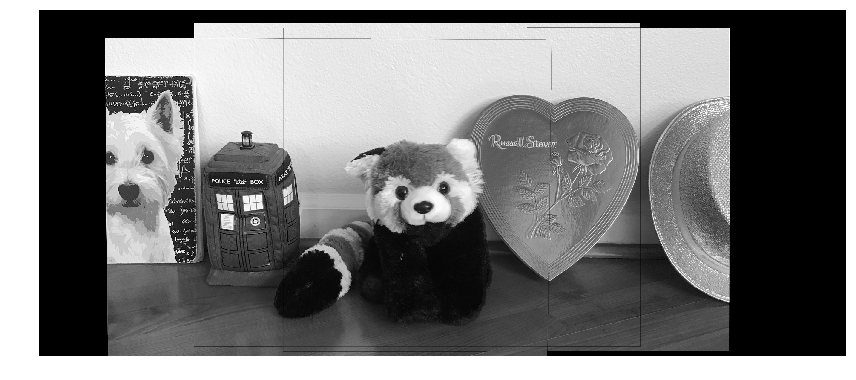

In [252]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized, cmap='gray')

plt.tight_layout()
ax.axis('off');

# 4. Merge the Images by Stitching along a minimum-cost path

To accomplish this we need:
1. Starting and ending points for the path
2. A cost array (a modified difference image)

This method is so powerful that, with a carefully constructed cost array, the seed points are essentially irrelevant. It just works!

**Define seed points**

In [253]:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

**Construct cost array**

This utility function exists to give a "cost break" for paths from the edge to the overlap region.

In [254]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

Use this function to generate the cost array.

In [270]:
# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                         pano1_mask & pano2_mask)

Allow the path to "slide" along top and bottom edges to the optimal horizontal position by setting top and bottom edges to zero cost.

In [271]:
costs12[0,  :] = 0
costs12[-1, :] = 0

Our cost array now looks like this! Kinda Scary

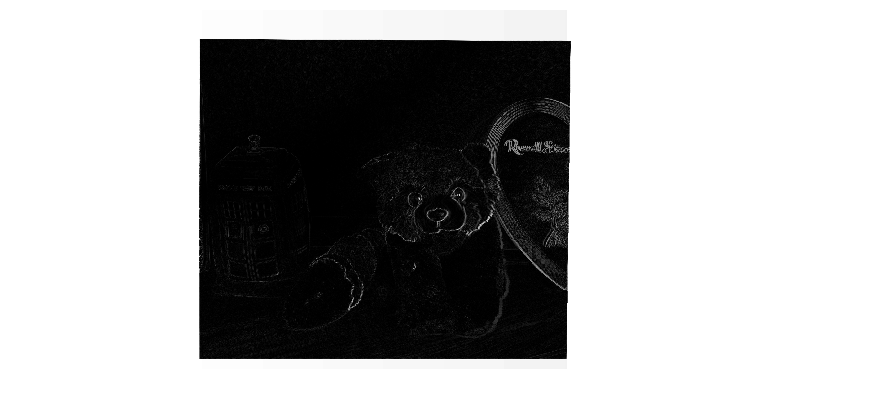

In [272]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.imshow(costs12, cmap='gray', interpolation='none')

ax.axis('off');


**Find the minimum-cost path (MCP)**
Use skimage.graph.route_through_array to find an optimal path through the cost array

In [278]:
from skimage.graph import route_through_array

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

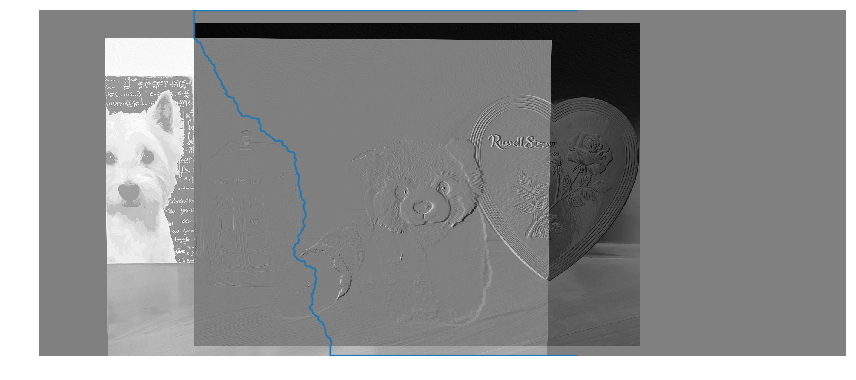

In [279]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano1_warped - pano2_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

**Filling the mask**
Turn that path into a mask, which will be 1 where we want the left image to show through and zero elsewhere. We need to fill the left side of the mask with ones over to our path.

In [281]:
# Start with an array of zeros and place the path
mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1

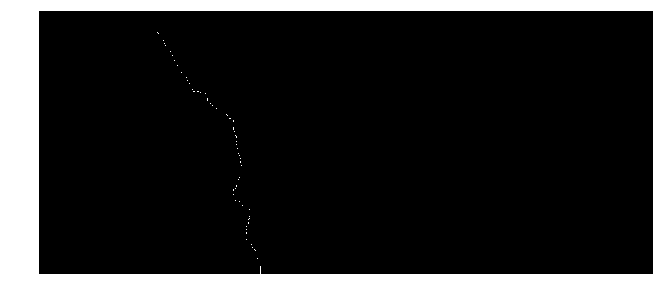

In [282]:
fig, ax = plt.subplots(figsize=(11, 11))

# View the path in black and white
ax.imshow(mask0, cmap='gray')

ax.axis('off');

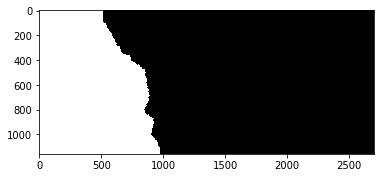

In [283]:
from skimage.measure import label

# Labeling starts with one at point (0, 0)
mask0 = (label(mask0, connectivity=1, background=-1) == 1)

# The result
plt.imshow(mask0, cmap='gray');

Looks good for a boarder between image 1 and image 2, rinse and repeat to find boarder for image 2 and 3... first, build the cost array

In [284]:
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs23 = generate_costs(np.abs(pano2_warped - pano3_warped),
                         pano2_mask & pano3_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs23[0,  :] = 0
costs23[-1, :] = 0

**Add an additional constraint this time,** to prevent this path crossing the prior one!

In [286]:
costs23[mask0 > 0] = 1

Check the result

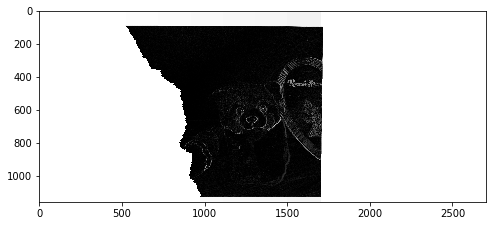

In [287]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs12, cmap='gray');

In [290]:
# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs23, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

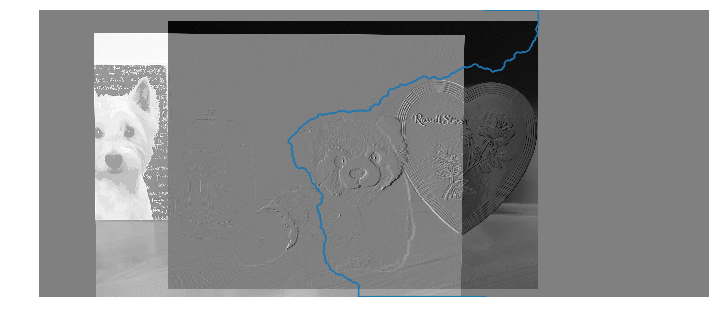

In [291]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano1_warped - pano2_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);

ax.axis('off');

Initialize the mask by placing the path in a new array

In [292]:
mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1

Fill the right side this time, again using skimage.measure.label - the label of interest is 2

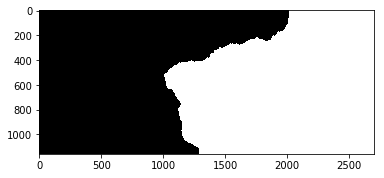

In [293]:
mask2 = (label(mask2, connectivity=1, background=-1) == 3)

# The result
plt.imshow(mask2, cmap='gray');

**Final mask**
The last mask for the middle image is one of exclusion - it will be displayed everywhere mask0 and mask2 are not.

In [334]:
mask1 = ~(mask0 | mask2).astype(bool)

Define a convenience function to place masks in alpha channels

In [335]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

Obtain final, alpha blended individual images and inspect them

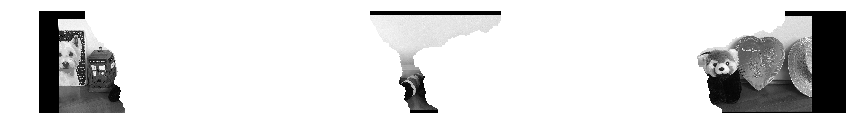

In [336]:
pano1_final = add_alpha(pano1_warped, mask0)
pano2_final = add_alpha(pano2_warped, mask1)
pano3_final = add_alpha(pano3_warped, mask2)

compare(pano1_final, pano2_final, pano3_final, figsize=(12, 12))

Plot all three together and view the results!

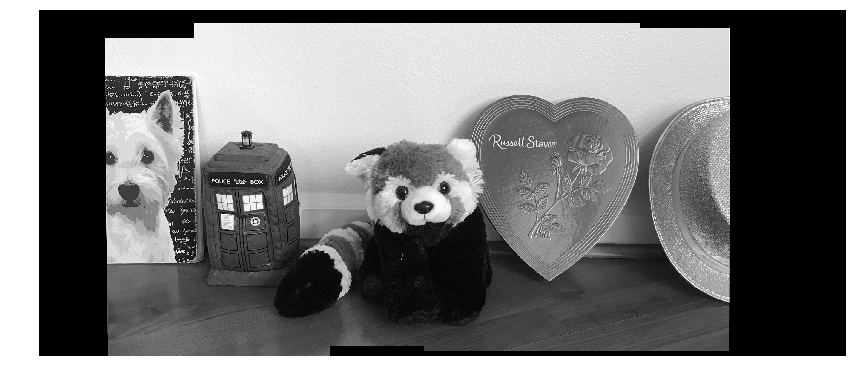

In [337]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')
ax.imshow(pano3_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

# Add the Color

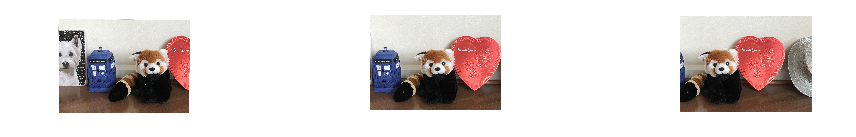

In [339]:
# Identical transforms as before, except
#   * Operating on original color images
#   * filling with cval=0 as we know the masks
pano1_color = warp(pano_imgs[1], (model_robust12 + offset2).inverse, order=3,
                   output_shape=output_shape, cval=0)

pano2_color = warp(pano_imgs[2], offset1.inverse, order=3, #reference image no offset
                   output_shape=output_shape, cval=0)

pano3_color = warp(pano_imgs[3], (model_robust23 + offset2).inverse, order=3,
                   output_shape=output_shape, cval=0)

# compare(pano1_color, pano2_color, pano3_color, figsize=(12, 10)); #checking to see if aligned

In [368]:
# Have to remove the 4th dimension that is added on during the warping 
# add_alpha function only accepts MxNx3 for RGB
pano1_color=pano1_color[:,:,0:3]
pano2_color=pano2_color[:,:,0:3]
pano3_color=pano3_color[:,:,0:3]


Apply the custom alpha channel masks

In [369]:
pano1_final = add_alpha(pano1_color, mask0)
pano2_final = add_alpha(pano2_color, mask1)
pano3_final = add_alpha(pano3_color, mask2)

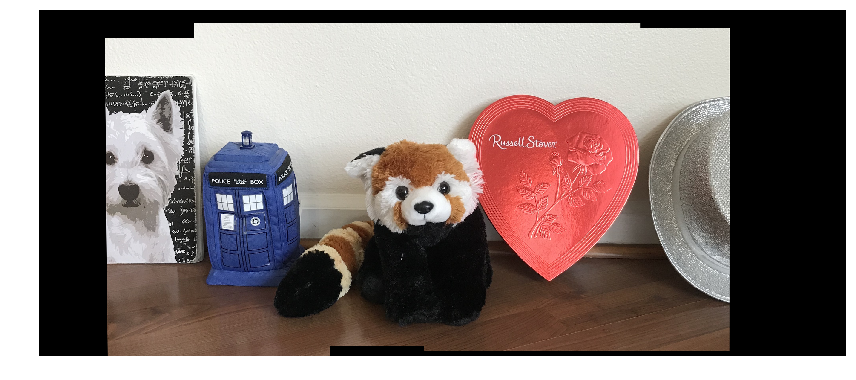

In [370]:
#Display Combined Panorama

fig, ax = plt.subplots(figsize=(12, 12))

# Turn off matplotlib's interpolation
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')
ax.imshow(pano3_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

Save the results!

In [372]:
from skimage.color import gray2rgb

# Start with empty image
pano_combined = np.zeros_like(pano1_color)

# Place the masked portion of each image into the array
# masks are 2d, they need to be (M, N, 3) to match the color images
pano_combined += pano1_color * gray2rgb(mask0)
pano_combined += pano2_color * gray2rgb(mask1)
pano_combined += pano3_color * gray2rgb(mask2)


# Save the output - precision loss warning is expected
# moving from floating point -> uint8
io.imsave('./pano-advanced-output.png', pano_combined)

/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
